In [7]:
# # The slab detachment benchmark
#
# Slab detachment benchark, as outlined  [Schmalholz, 2011](https://www.sciencedirect.com/science/article/pii/S0012821X11000252?casa_token=QzaaLiBMuiEAAAAA:wnpjH88ua6bj73EAjkoqmtiY5NWi9SmH7GSjvwvY_LNJi4CLk6vptoN93xM1kyAwdWa2rnbxa-U) and [Glerum et al., 2018](https://se.copernicus.org/articles/9/267/2018/se-9-267-2018.pdf)
# - [ASPECT benchmark](https://aspect-documentation.readthedocs.io/en/latest/user/benchmarks/benchmarks/slab_detachment/doc/slab_detachment.html)

# marker chain method, see [Braun et al., 2008](https://www.sciencedirect.com/science/article/pii/S0031920108000940)


In [8]:
from petsc4py import PETSc
import underworld3 as uw
import numpy as np
import sympy
import petsc4py
import pyvista as pv

import glob
import os
from underworld3.cython.petsc_discretisation import petsc_dm_find_labeled_points_local

options = PETSc.Options()
options["snes_converged_reason"] = None
options["snes_monitor_short"] = None

sys = PETSc.Sys()
sys.pushErrorHandler("traceback")

if uw.mpi.size == 1:
    render = True
else:
    render = False
    
### linear or nonlinear version
linear = False ### False for NL version
# %%
## number of steps
nsteps = 10
### distance between elements, in km
res = 20
### Recycle rate of particles
recycle_rate = 0

outputPath = f'./output/slabDetachment_res={res}km_recycleRate={recycle_rate}_markerchain/'

reload = False

if uw.mpi.rank == 0:
    # checking if the directory
    # exist or not.
    if os.path.exists(outputPath):
        reload = True
        restart_step = os.path.basename(max(glob.iglob(outputPath + 'swarm*xmf'), key=os.path.getctime))[-9:-4]
        pv_mesh_data = pv.XdmfReader(outputPath + f'step_{restart_step}.xdmf').read()
        time_d =  pv_mesh_data['time_time'][0]
    else:
        # if the demo_folder directory is not present 
        # then create it.
        os.makedirs(outputPath)
        step = 0
        time = 0.
        restart_step = -1

In [9]:
u = uw.scaling.units

### make scaling easier
ndim = uw.scaling.non_dimensionalise
nd   = uw.scaling.non_dimensionalise
dim  = uw.scaling.dimensionalise 

# %%
### set reference values
velocity     = 1e-11 * u.meter / u.second
model_height = 660.  * u.kilometer
bodyforce    = 3300  * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
mu           = 1e22  * u.pascal * u.second

KL = model_height
Kt = KL / velocity
# KM = bodyforce * KL**2 * Kt**2
KM = mu * KL * Kt


scaling_coefficients  = uw.scaling.get_coefficients()

scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt
scaling_coefficients["[mass]"]= KM

scaling_coefficients

# %%
ND_gravity = nd( 9.81 * u.meter / u.second**2 )

# %%
ND_gravity * nd(3.3e3*u.kilogram/u.meter**3)

141016.78800000006

In [10]:
### add material index
BGIndex = 0
SlabIndex = 1

# %% [markdown]
# Set up dimensions of model and sinking block

# %%
xmin, xmax = 0., ndim(1000*u.kilometer)
ymin, ymax = 0., ndim(660*u.kilometer)

# %%
resx = int(1000 / res)
resy = int(660 / res)

# %%
if uw.mpi.rank == 0:
    print(f'')
    print(f'resx: {resx}')
    print(f'resy: {resy}')
    print(f'proc: {uw.mpi.size}')
    print(f'')

mesh = uw.meshing.StructuredQuadBox(elementRes =(int(resx),int(resy)),
                                    minCoords=(xmin,ymin), 
                                    maxCoords=(xmax,ymax))

dx,dy = (xmax-xmin)/resx,(ymax-ymin)/resy

botwall = petsc_dm_find_labeled_points_local(mesh.dm,"Bottom")
topwall = petsc_dm_find_labeled_points_local(mesh.dm,"Top")


resx: 50
resy: 33
proc: 1



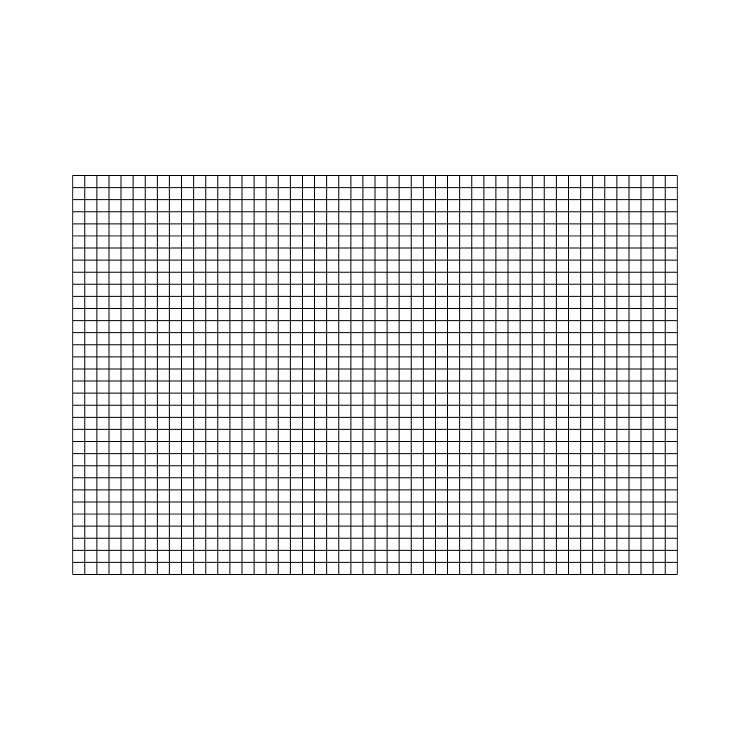

In [11]:
if uw.mpi.size == 1:

    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 750]
    #pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True

    # pv.start_xvfb()

    mesh.vtk(outputPath + "SD_mesh.vtk")
    pvmesh = pv.read(outputPath + "SD_mesh.vtk")

    # with mesh1.access():
        # usol = stokes.u.data.copy()


    pl = pv.Plotter(window_size=(750, 750))

    pl.add_mesh(pvmesh,'Black', 'wireframe')


    pl.show(cpos="xy")

In [12]:
# %%
v = uw.discretisation.MeshVariable('U',    mesh,  mesh.dim, degree=2 )
p = uw.discretisation.MeshVariable('P',    mesh, 1, degree=1,  continuous=True)
phi = uw.discretisation.MeshVariable("phi", mesh, 1, degree=1,continuous=True)

### Create mesh variables to project stuff onto
strain_rate_inv2 = uw.discretisation.MeshVariable("SR", mesh, 1, degree=2)
dev_stress_inv2 = uw.discretisation.MeshVariable("stress", mesh, 1, degree=1)
node_viscosity = uw.discretisation.MeshVariable("viscosity", mesh, 1, degree=1)

timeField      = uw.discretisation.MeshVariable("time", mesh, 1, degree=1)
materialField  = uw.discretisation.MeshVariable("material", mesh, 1, degree=1)

stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p )
stokes.constitutive_model = uw.constitutive_models.ViscousFlowModel
sol_vel = sympy.Matrix([0., 0.])
# No slip left & right & free slip top & bottom
stokes.add_dirichlet_bc( sol_vel, "Left" ) 
stokes.add_dirichlet_bc( sol_vel, "Right")
stokes.add_dirichlet_bc( [None,0.], "Top")  
stokes.add_dirichlet_bc( [None,0.], "Bottom")

In [13]:
from scipy.spatial import distance
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
def points_in_polygon(pts,polygon):
    pts = np.asarray(pts,dtype='float32')
    polygon = np.asarray(polygon,dtype='float32')
    contour2 = np.vstack((polygon[1:], polygon[:1]))
    test_diff = contour2-polygon
    mask1 = (pts[:,None] == polygon).all(-1).any(-1)
    m1 = (polygon[:,1] > pts[:,None,1]) != (contour2[:,1] > pts[:,None,1])
    slope = ((pts[:,None,0]-polygon[:,0])*test_diff[:,1])-(test_diff[:,0]*(pts[:,None,1]-polygon[:,1]))
    m2 = slope == 0
    mask2 = (m1 & m2).any(-1)
    m3 = (slope < 0) != (contour2[:,1] < polygon[:,1])
    m4 = m1 & m3
    count = np.count_nonzero(m4,axis=-1)
    mask3 = ~(count%2==0)
    mask = mask1 | mask2 | mask3
    return mask

def init_phi(mesh,interfaceSwarm,phi):
    with interfaceSwarm.access():
        interface_coords = interfaceSwarm.data
        index = uw.kdtree.KDTree(interfaceSwarm.data)
        index.build_index()
    indices, dist_sqr, found = index.find_closest_point(mesh.data)
    phi_values = np.sqrt(dist_sqr)
    
    line = mesh.data[topwall]
    x1,y1 = line[:,0],line[:,1]
    zipxy = zip(x1,y1)
    zipxy = sorted(zipxy,reverse=True)
    x2,y2 = zip(*zipxy) 
    line[:,0] = x2 
    line[:,1] = y2
    point_leftwall = np.array([xmin,interface_coords[0,1]])
    point_rightwall = np.array([xmax,interface_coords[0,1]])
    point_righttop = np.array([xmax,ymax])
    point_lefttop = np.array([xmin,ymax])
    polygon = np.vstack([point_leftwall,interface_coords,point_rightwall])
    polygon = np.concatenate((polygon,line),axis=0)
    polygon = np.vstack([polygon, polygon[0]])
    mask = points_in_polygon(mesh.data, polygon)
    
    phi_values[~mask] = -phi_values[~mask]
    
    with mesh.access(phi):
        phi.data[:,0] = phi_values
    return 

In [15]:
nodal_strain_rate_inv2 = uw.systems.Projection(mesh, strain_rate_inv2)
nodal_strain_rate_inv2.uw_function = stokes.Unknowns.Einv2
nodal_strain_rate_inv2.smoothing = 0.
nodal_strain_rate_inv2.petsc_options.delValue("ksp_monitor")

nodal_visc_calc = uw.systems.Projection(mesh, node_viscosity)
nodal_visc_calc.uw_function = stokes.constitutive_model.Parameters.shear_viscosity_0
nodal_visc_calc.smoothing = 0.
nodal_visc_calc.petsc_options.delValue("ksp_monitor")


nodal_tau_inv2 = uw.systems.Projection(mesh, dev_stress_inv2)
nodal_tau_inv2.uw_function = 2. * stokes.constitutive_model.Parameters.shear_viscosity_0 * stokes.Unknowns.Einv2
nodal_tau_inv2.smoothing = 0.
nodal_tau_inv2.petsc_options.delValue("ksp_monitor")

In [16]:
xmin_slab = nd((500-40)*u.kilometer)
xmax_slab = nd((500+40)*u.kilometer)
ymax_slab = nd((660-80)*u.kilometer)
ymin_slab = nd((660-330)*u.kilometer)

x = np.linspace(xmin,xmin_slab,47)
y = np.ones_like(x)*ymax_slab 
line1 = np.ascontiguousarray(np.array([x,y]).T)

y = np.linspace(ymin_slab ,ymax_slab,26)
x = np.ones_like(y)*xmin_slab 
line1v = np.ascontiguousarray(np.array([x,y]).T)

x = np.linspace(xmin_slab,xmax_slab,9)
y = np.ones_like(x)*ymin_slab
line2 = np.ascontiguousarray(np.array([x,y]).T)

y = np.linspace(ymin_slab ,ymax_slab,26)
x = np.ones_like(y)*xmax_slab
line2v = np.ascontiguousarray(np.array([x,y]).T)

x = np.linspace(xmax_slab ,xmax,47)
y = np.ones_like(x)*ymax_slab 
line3 = np.ascontiguousarray(np.array([x,y]).T)

interface_coords = np.concatenate((line1,line1v,line2,line2v,line3),axis=0)
                
interfaceSwarm = uw.swarm.Swarm(mesh)
interfaceSwarm.add_particles_with_coordinates(interface_coords)  

passiveSwarm_L = uw.swarm.Swarm(mesh)
passiveSwarm_R = uw.swarm.Swarm(mesh)
y = np.linspace(ymin_slab ,ymax_slab, 20)
x0 = np.ones_like(y)*xmin_slab 
x1 = np.ones_like(y)*xmax_slab
tracers_L = np.vstack([x0,y]).T
tracers_R = np.vstack([x1,y]).T
passiveSwarm_L.add_particles_with_coordinates(np.ascontiguousarray(tracers_L))
passiveSwarm_R.add_particles_with_coordinates(np.ascontiguousarray(tracers_R))

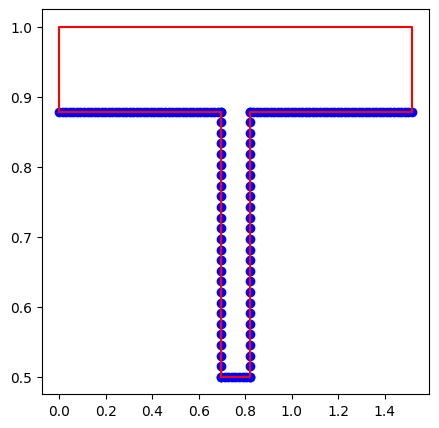

In [17]:
if uw.mpi.size==1 and render == True:
    #polygon = interface_coords
    import numpy as np
    #from skimage.measure import points_in_poly
    import matplotlib.pyplot as plt
    
    line = mesh.data[topwall]
    x1,y1 = line[:,0],line[:,1]
    zipxy = zip(x1,y1)
    zipxy = sorted(zipxy,reverse=True)
    x2,y2 = zip(*zipxy) 
    line[:,0] = x2 
    line[:,1] = y2
    point_leftwall = np.array([xmin,interface_coords[0,1]])
    point_rightwall = np.array([xmax,interface_coords[0,1]])
    point_righttop = np.array([xmax,ymax])
    point_lefttop = np.array([xmin,ymax])
    polygon = np.vstack([point_leftwall,interface_coords,point_rightwall])
    polygon = np.concatenate((polygon,line),axis=0)
    polygon = np.vstack([polygon, polygon[0]])
    
    fig, ax1 = plt.subplots(nrows=1, figsize=(5,5))
    ax1.plot(*polygon.T, color="red")
    ax1.scatter(interface_coords[:,0],interface_coords[:,1],c="blue")
    # ax1.set_xlim([-5,5])
    # ax1.set_ylim([-6.6,0.])
    #plt.show()

In [20]:
init_phi(mesh,interfaceSwarm,phi)

densityBG     = nd(3150* u.kilogram / u.metre**3)
densitySlab   = nd(3300* u.kilogram / u.metre**3)

use_diff  = False
alphah = 1*dy
def material_parameter_fn(c1,c2,alphah):
    return sympy.Piecewise((c1,phi.sym[0] <= -alphah),
                           (c2,phi.sym[0] > alphah),
                           ((c2-c1)*phi.sym[0]/alphah/2.+(c1+c2)/2, True))
if use_diff:
    density_fn = material_parameter_fn(densityBG,densitySlab,alphah) 
    print("use_diff")
else:
    density_fn = sympy.Piecewise((densitySlab,phi.sym[0] > 0.0),(densityBG, True))  

stokes.bodyforce = sympy.Matrix([0, -1 * ND_gravity * density_fn])
if uw.mpi.size == 1:
    stokes.petsc_options['pc_type'] = 'lu'
stokes.tolerance = 1.0e-5
stokes.petsc_options["snes_converged_reason"] = None

viscBG_L = ndim(1e21 * u.pascal * u.second)
viscSlab_L = ndim(2e24 * u.pascal * u.second)
if use_diff:
    viscosity_L_fn  = material_parameter_fn(viscBG_L,viscSlab_L,alphah)
else:
    viscosity_L_fn  = sympy.Piecewise((viscSlab_L,phi.sym[0] >= 0.0),(viscBG_L, True))
stokes.constitutive_model.Parameters.shear_viscosity_0 = viscosity_L_fn
stokes.saddle_preconditioner = 1.0 / viscosity_L_fn
stokes.solve(zero_init_guess=False)

viscBG = ndim(1e21 * u.pascal * u.second)
if linear == False: 
    n = 4
    Slab_visc      = nd(4.75e11*u.pascal*u.second**(1/n))
    viscSlab = sympy.Max(sympy.Min(Slab_visc * sympy.Pow(stokes.Unknowns.Einv2, (1/n-1)), nd(1e25*u.pascal*u.second)), nd(1e21*u.pascal*u.second))
else:
    n = 1
    Slab_visc      = nd(2e23*u.pascal*u.second)
    viscSlab       = sympy.Max(sympy.Min(Slab_visc, nd(1e25*u.pascal*u.second)), nd(1e21*u.pascal*u.second))

if use_diff:
    visc_fn = material_parameter_fn(viscBG,viscSlab,alphah)
else:
    visc_fn = sympy.Piecewise((viscSlab,phi.sym[0] > 0.0),(viscBG, True))

material_fn = sympy.Piecewise((SlabIndex,phi.sym[0] > 0.0,),(BGIndex, True))

stokes.constitutive_model.Parameters.shear_viscosity_0 = visc_fn
stokes.saddle_preconditioner = 1.0 / visc_fn

  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve converged due to CONVERGED_FNORM_ABS iterations 0


In [21]:
def saveData(step, outputPath, time):
    mesh.petsc_save_checkpoint(index=step, 
                               meshVars=[v, p, strain_rate_inv2,node_viscosity, timeField,phi], 
                                outputPath=outputPath)
    interfaceSwarm.petsc_save_checkpoint('interfaceSwarm', step, outputPath)
    passiveSwarm_L.petsc_save_checkpoint('PT_L', step, outputPath)
    passiveSwarm_R.petsc_save_checkpoint('PT_R', step, outputPath)

In [29]:
def plot_mesh_var(title,mesh,var_fn,cmap,showVar=False,showFig=True):
    import numpy as np
    import pyvista as pv
    import vtk
    from matplotlib.colors import ListedColormap
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 750]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    if showVar:
        with mesh.access():
            points = np.zeros((mesh.data.shape[0],3))
            points[:,0] = mesh.data[:,0]
            points[:,1] = mesh.data[:,1]
            point_cloud = pv.PolyData(points)
            point_cloud.point_data["M"] = uw.function.evalf(var_fn, mesh.data)
        
        #pl.add_points(point_cloud, color="red",render_points_as_spheres=False, point_size=3, opacity=0.5)
        pl.add_mesh(point_cloud, cmap=cmap, edge_color="Black", show_edges=False, scalars='M',
                        use_transparency=False, opacity=0.95, point_size= 3)
    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data()
    pvmesh.clear_point_data()

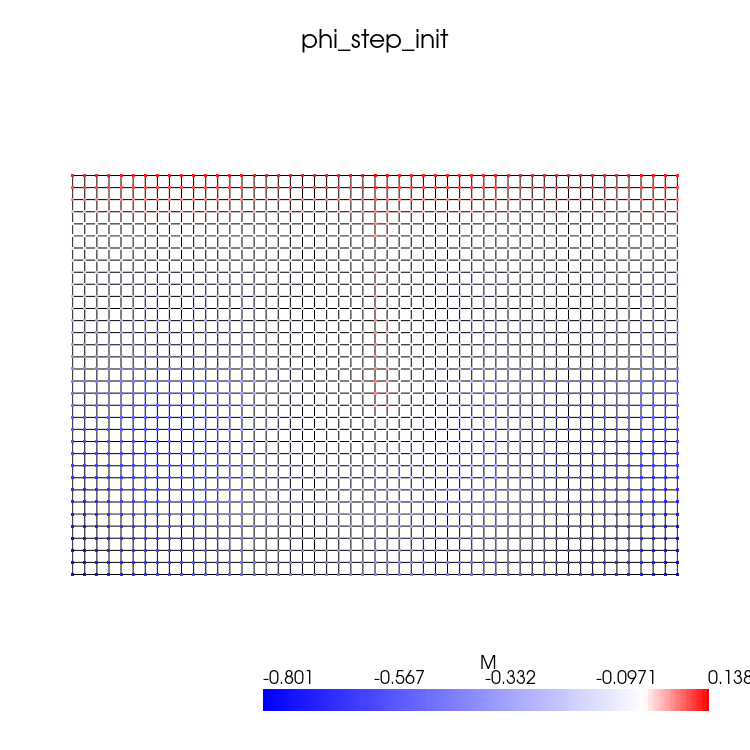

In [30]:
# from matplotlib.colors import ListedColormap

# var_fn = phi.sym
# with mesh.access(var_fn):
#      var_data = uw.function.evalf(var_fn, mesh.data)
# vmin = var_data.min()
# vmax = var_data.max()

# radio = -vmin/(vmax-vmin) 
# from matplotlib.colors import LinearSegmentedColormap
# colors = [(0, "blue"), (radio, "white"), (1, "red")]
# cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)


# plot_mesh_var("phi_step_init",mesh,phi.sym,cmap,showVar=True,showFig=True)

In [ ]:
def updateFields(time):
    with mesh.access(timeField):
        timeField.data[:,0] = dim(time, u.megayear).m

    nodal_strain_rate_inv2.solve()
    # matProj.uw_function = materialVariable.sym[0] 
    # matProj.solve(_force_setup=True)
    nodal_visc_calc.uw_function = stokes.constitutive_model.Parameters.shear_viscosity_0
    nodal_visc_calc.solve(_force_setup=True)
    nodal_tau_inv2.uw_function = 2. * stokes.constitutive_model.Parameters.shear_viscosity_0 * stokes.Unknowns.Einv2
    nodal_tau_inv2.solve(_force_setup=True)



Save data: 


  Nonlinear  solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  Nonlinear  solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  Nonlinear  solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


Step:   0, time:   0.00 Myr, Necking width:   80.00 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve did not converge due to DIVERGED_LINE_SEARCH iterations 7


Step:   1, time:   3.34 Myr, Necking width:   74.86 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve did not converge due to DIVERGED_LINE_SEARCH iterations 0


Step:   2, time:   6.68 Myr, Necking width:   69.69 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve did not converge due to DIVERGED_LINE_SEARCH iterations 1


Step:   3, time:   9.66 Myr, Necking width:   65.14 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  N

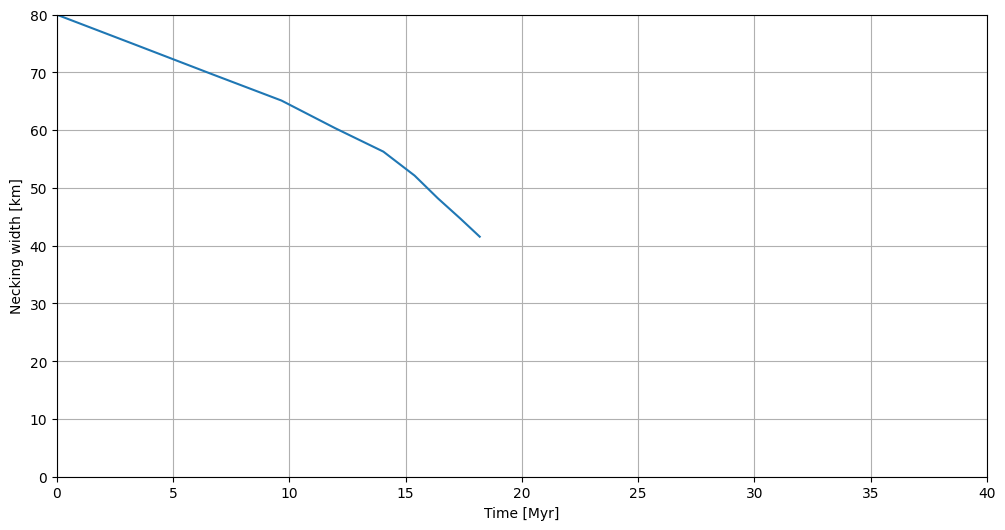

NameError: name 'plot_mat' is not defined

In [22]:
while step < nsteps:
    
    ### Get the x coordinates of the passive tracers
    with passiveSwarm_L.access():
        PS_L =  uw.utilities.gather_data(passiveSwarm_L.data[:,0], bcast=True)
    
    with passiveSwarm_R.access():
        PS_R =  uw.utilities.gather_data(passiveSwarm_R.data[:,0], bcast=True)
        
    L_xmax = PS_L.max()
    R_xmin = PS_R.min()
    
    #### calculate the minimum necking width   
    NeckWidth[step]    = R_xmin - L_xmax
    time_array[step]   = time
        
    ### save loop
    if step % 5 == 0 and step != restart_step:
        if uw.mpi.rank==0:
            print(f'\n\nSave data: \n\n')
        ### update fields first
        updateFields(time = time)
        ### save mesh variables
        saveData(step=step, outputPath=outputPath, time = time)

        ### remove nan values, if any. Convert to km and Myr
        NeckWidth_d = dim(NeckWidth[~np.isnan(NeckWidth)], u.kilometer)
        time_array_d   = dim(time_array[~np.isnan(time_array)], u.megayear)
        if uw.mpi.rank == 0:
            np.savez_compressed(f'{outputPath}/NeckWidth-{res}km', NeckWidth_d.m)
            np.savez_compressed(f'{outputPath}/modelTime-{res}km', time_array_d.m)
        
    ### print some stuff    
    if uw.mpi.rank==0:
        print(f"\n\nStep: {str(step).rjust(3)}, time: {dim(time, u.megayear).m:6.2f} Myr, Necking width:  {dim(NeckWidth[step], u.kilometer).m:6.2f} km \n\n")
        
    
    ### solve stokes 
    stokes.solve(zero_init_guess=False)
    ### estimate dt
    dt = 0.5 * stokes.estimate_dt()

    ### advect the swarm
    interfaceSwarm.advection(stokes.u.sym, dt, corrector=False, evalf=True)
    passiveSwarm_L.advection(stokes.u.sym, dt, corrector=False, evalf=True)
    passiveSwarm_R.advection(stokes.u.sym, dt, corrector=False, evalf=True)

    init_phi(mesh,interfaceSwarm,phi)
      
    step+=1
    time+=dt

# %% [markdown]
# #### Check the results against the benchmark 

# %%
### remove nan values, if any. Convert to km and Myr
NeckWidth_d = dim(NeckWidth[~np.isnan(NeckWidth)], u.kilometer)
time_array_d   = dim(time_array[~np.isnan(time_array)], u.megayear)
if uw.mpi.rank == 0:
    np.savez_compressed(f'{outputPath}NeckWidth-{res}km', NeckWidth_d.m)
    np.savez_compressed(f'{outputPath}modelTime-{res}km', time_array_d.m)

# %%
### remove nan values, if any. Convert to km and Myr
NeckWidth_d = dim(NeckWidth[~np.isnan(NeckWidth)], u.kilometer)
time_array_d   = dim(time_array[~np.isnan(time_array)], u.megayear)
if uw.mpi.rank == 0:
    np.savez_compressed(f'{outputPath}NeckWidth-{res}km', NeckWidth_d.m)
    np.savez_compressed(f'{outputPath}modelTime-{res}km', time_array_d.m)


if uw.mpi.rank==0:
    print('Initial: t = {0:.3f}, w = {1:.3f}'.format(time_array_d[0], NeckWidth_d[0]))
    print('Final:   t = {0:.3f}, w = {1:.3f}'.format(time_array_d[-1], NeckWidth_d[-1]))

    
if uw.mpi.rank==0:
        
    import matplotlib.pyplot as plt

    fig = plt.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(1,1,1)
    ax.plot(time_array_d.m, NeckWidth_d.m) 
    ax.set_xlabel('Time [Myr]')
    ax.set_ylabel('Necking width [km]')

    plt.ylim(0, 80)
    plt.xlim(0, 40)
    plt.grid()

    plt.savefig(f'{outputPath}slabDetachment_res={res}km_NeckWidth_markerchain.pdf', dpi=500)

    plt.show()

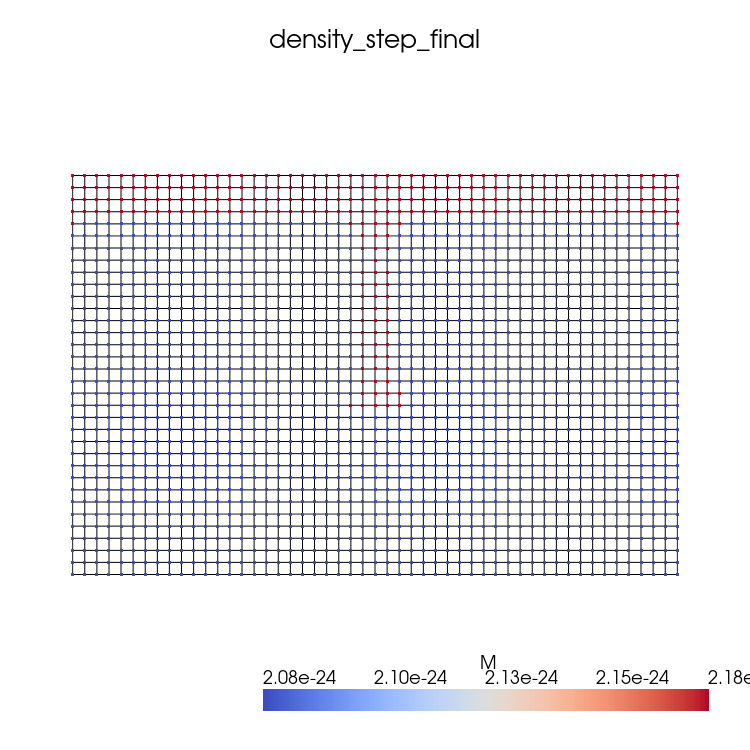

In [31]:
# %%
if uw.mpi.size==1 and render == True:
    plot_mesh_var("density_step_final",mesh,density_fn,'coolwarm',showVar=True,showFig=True)

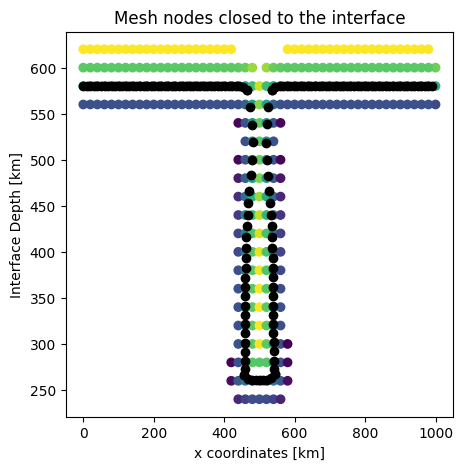

In [27]:
if uw.mpi.size==1 and render == True:
    with mesh.access():
        dis = dy*2
        dis_data = uw.function.evalf(phi.fn,mesh.data)
        condition = np.abs(dis_data) <=dis
        dis_plot = dis_data[condition]
        nodes_plot = mesh.data[condition]
    
    with interfaceSwarm.access():
        interface_coords = interfaceSwarm.data
        
    fname = "Mesh nodes closed to the interface"
    fig, ax1 = plt.subplots(nrows=1, figsize=(5,5))
    ax1.set(xlabel='x coordinates [km]', ylabel='Interface Depth [km]') 
    #ax1.set(xlabel='Time [Myrs]', ylabel='Interface Depth [km]') 
    ax1.set_title(fname)
    ax1.scatter(nodes_plot[:,0]*KL.m,nodes_plot[:,1]*KL.m,c=dis_plot)
    ax1.scatter(interface_coords[:,0]*KL.m,interface_coords[:,1]*KL.m,c = "k")
    # ax1.set_ylim([-500,-100])
    # ax1.set_xlim([0,6])
    # ax1.grid()
    #ax1.legend(loc = 'lower left',prop = {'size':8})
    plt.savefig(outputPath+fname,dpi=150,bbox_inches='tight')

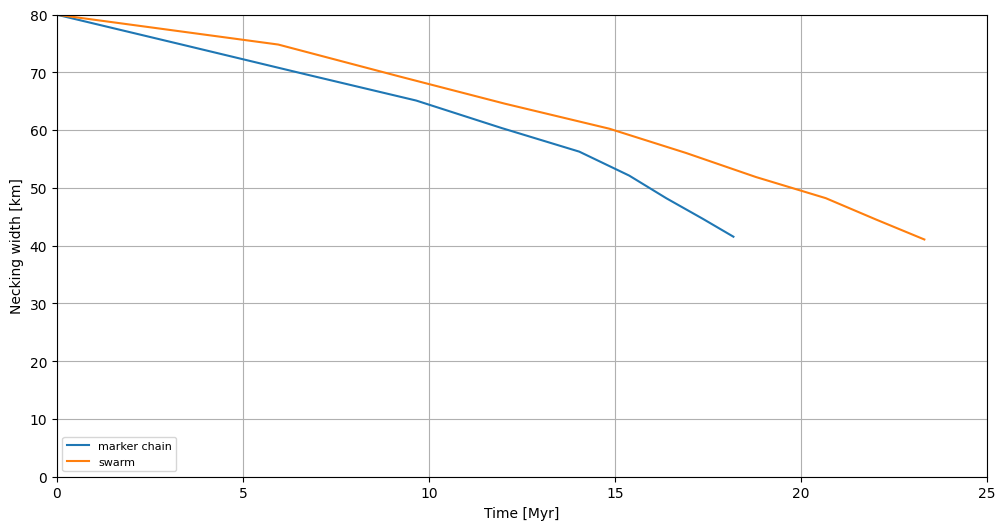

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(12, 6)
ax = fig.add_subplot(1,1,1)

fdir = f'./output/slabDetachment_res={res}km_recycleRate={recycle_rate}_markerchain/'
NeckWidth_d = np.load(f'{fdir}/NeckWidth-{res}km.npz')['arr_0']
time_array_d = np.load(f'{fdir}/modelTime-{res}km.npz')['arr_0']
ax.plot(time_array_d, NeckWidth_d,label='marker chain') 

fdir = f'./output/slabDetachment_res={res}km_recycleRate={recycle_rate}/'
NeckWidth_d = np.load(f'{fdir}/NeckWidth-{res}km.npz')['arr_0']
time_array_d = np.load(f'{fdir}/modelTime-{res}km.npz')['arr_0']
ax.plot(time_array_d, NeckWidth_d,label='swarm') 

ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Necking width [km]')
ax.legend(loc = 'lower left',prop = {'size':8})

plt.ylim(0, 80)
plt.xlim(0, 25)
plt.grid()
plt.savefig(f'{outputPath}slabDetachment_res={res}km_NeckWidth.pdf', dpi=500)
plt.show()